In [1]:
import subprocess
import os
import pandas as pd
import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
import dask
from scipy.interpolate import griddata
#from ocean_c_lab_tools import *
#from celluloid import Camera 
#import PyCO2SYS as csys
import seawater as sw
from roms_regrid import *

/tmp/ipykernel_1155063/3005166470.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
obs=xr.open_dataset('/global/cfs/cdirs/m4632/uheede/Hafro_obsdata/HVIN_1new.nc')

In [3]:
obs_lon=obs['lon'].load()+360
obs_lat=obs['lat'].load()
good_bins=(obs['iigood'].where(obs['iigood']<20).to_numpy())
good_bins_nn=good_bins[~np.isnan(good_bins)]
good_bins_nn = good_bins_nn.astype(int)


In [4]:
obs_sel=obs.isel(depth_dim=slice(np.min(good_bins_nn),np.max(good_bins_nn)))


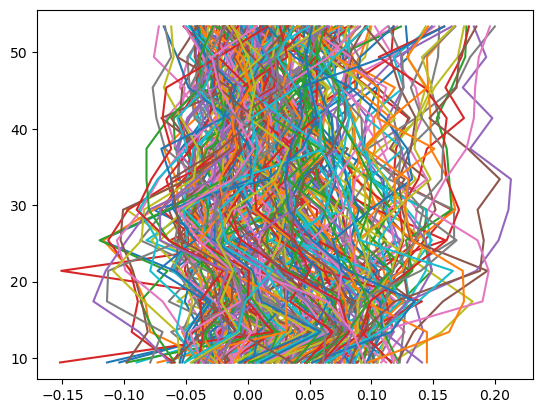

In [5]:
plt.plot(obs_sel['u'].isel(time_dim=slice(0,300)),obs_sel.depth)

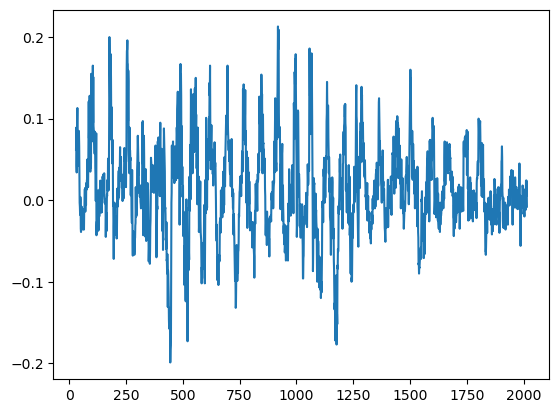

In [6]:
plt.plot(obs_sel['u'].isel(depth_dim=0).isel(time_dim=slice(0,6*24*14)))

In [7]:
obs_sel.depth.load()

<xarray.DataArray 'depth' (depth_dim: 12)> Size: 96B
array([53.39814123, 49.39814123, 45.39814123, 41.39814123, 37.39814123,
       33.39814123, 29.39814123, 25.39814123, 21.39814123, 17.39814123,
       13.39814123,  9.39814123])
Dimensions without coordinates: depth_dim

In [8]:
model=xr.open_mfdataset('/global/cfs/cdirs/m4746/Users/ulla/Iceland4_multidye_np4/z_Iceland4_linedye_rnd.201206*.nc', combine='nested', concat_dim=["time"])

u_sub=model['u'].isel(xi_u=slice(1100,1250)).isel(eta_rho=slice(500,650))
v_sub=model['v'].isel(xi_rho=slice(1100,1250)).isel(eta_v=slice(500,650))

In [9]:
u_sub

<xarray.DataArray 'u' (time: 304, depth: 40, eta_rho: 150, xi_u: 150)> Size: 1GB
dask.array<getitem, shape=(304, 40, 150, 150), dtype=float32, chunksize=(48, 40, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 160B -0.0 -0.5 -1.0 -1.5 ... -240.0 -260.0 -280.0
Dimensions without coordinates: time, eta_rho, xi_u
Attributes:
    long_name:  3d zonal vel. field
    units:      m/s

In [10]:
grid=xr.open_dataset('/global/cfs/cdirs/m4632/uheede/work/Iceland4_BGC/INPUT/Iceland4_grd.nc')
grid_subsetu=grid.isel(xi_rho=slice(1100,1251)).isel(eta_rho=slice(500,650))
grid_subsetv=grid.isel(xi_rho=slice(1100,1250)).isel(eta_rho=slice(500,651))

In [11]:
u_rg=roms_regrid_u(grid_subsetu,u_sub)

In [12]:
v_rg=roms_regrid_v(grid_subsetv,v_sub)

In [13]:
u_rg.load()
v_rg.load()

<xarray.DataArray (time: 304, depth: 40, lat: 150, lon: 150)> Size: 1GB
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ..., -0.02033059,
          -0.02123661, -0.02247282],
         [ 0.        ,  0.        ,  0.        , ..., -0.0201064 ,
          -0.02144704, -0.02199362],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.00628526,
           0.00571439,  0.00482495],
         [ 0.        ,  0.        ,  0.        , ...,  0.00698367,
           0.00616417,  0.00603302],
...
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan],
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan],
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan],
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan],
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan],
         [ 0.        ,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * depth    (depth) float32 160B -0.0 -0.5 -1.0 -1.5 ... -240.0 -260.0 -280.0
  * lon      (lon) float64 1kB 338.4 338.4 338.4 338.4 ... 338.5 338.5 338.5
  * lat      (lat) float64 1kB 64.36 64.36 64.36 64.36 ... 64.4 64.4 64.4 64.4
Dimensions without coordinates: time
Attributes:
    regrid_method:  bilinear

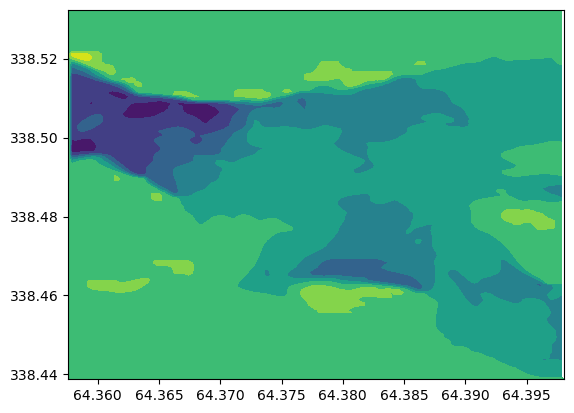

In [39]:
plt.contourf(u_rg.lat,u_rg.lon,u_rg.isel(depth=1).isel(time=0))

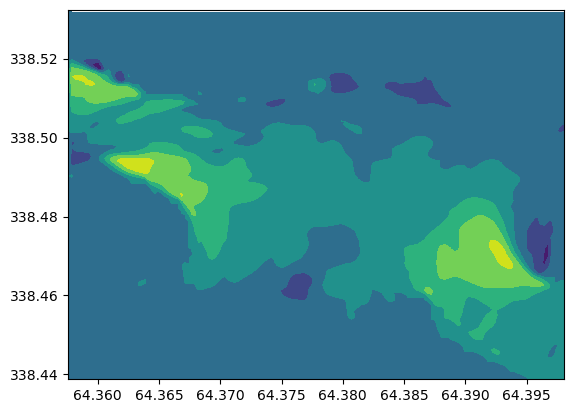

In [40]:
plt.contourf(v_rg.lat,v_rg.lon,v_rg.isel(depth=1).isel(time=0))

In [72]:
#64.392883°N 21.466417°W
obs_lon=338.51
obs_lat=64.39

In [52]:
obs_lon

338.535

In [89]:
u_selected = u_rg.sel(lat=obs_lat, method='nearest').sel(lon=obs_lon, method='nearest')
v_selected = v_rg.sel(lat=obs_lat, method='nearest').sel(lon=obs_lon, method='nearest')

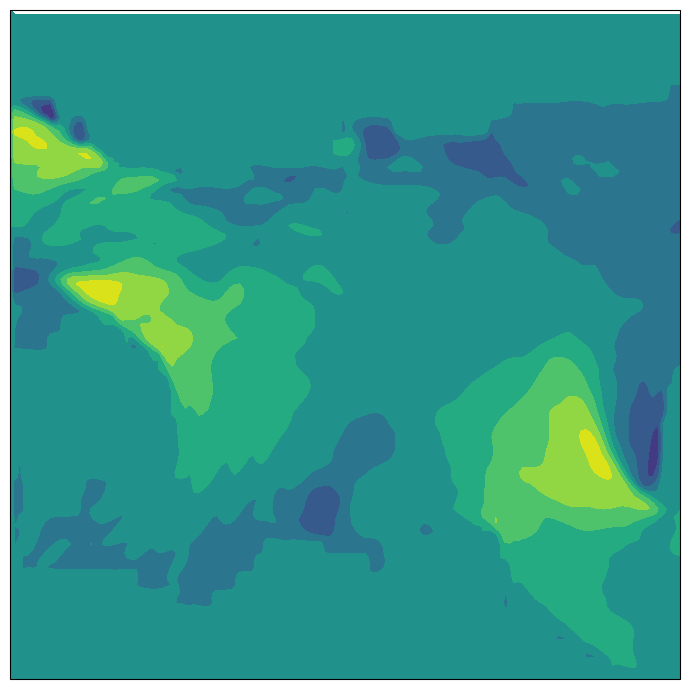

In [90]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(figsize=(7,7),subplot_kw={'projection': ccrs.Mercator()},layout='tight')
ax.contourf(v_rg.lon,v_rg.lat,v_rg.isel(time=0).isel(depth=0),transform=ccrs.PlateCarree())
#ax.set_extent([-21.5, -21.45, 64.39, 64.4], ccrs.PlateCarree())


In [91]:
u_selected=u_selected*10
v_selected=v_selected*10

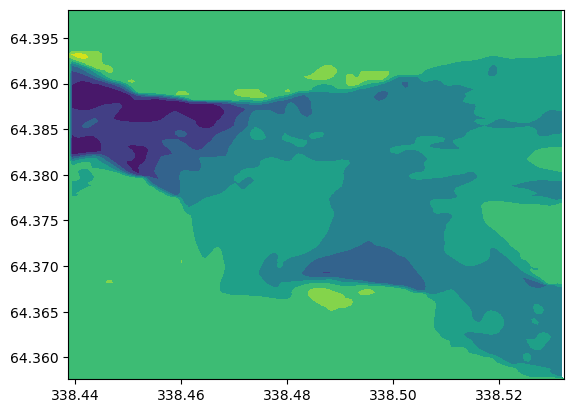

In [71]:
plt.contourf(u_rg.lon,u_rg.lat,u_rg.isel(time=0).isel(depth=0))

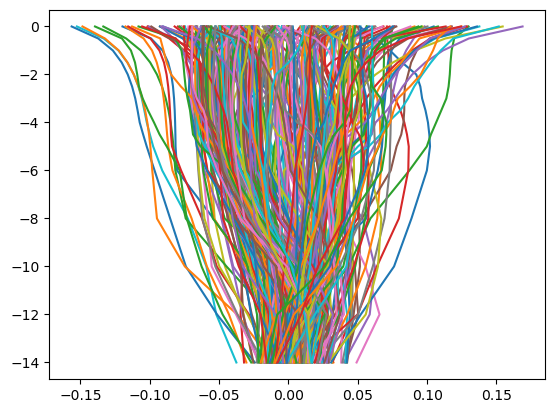

In [74]:
for x in u_selected.time:    
    plt.plot(u_selected.isel(time=x).squeeze(),u_selected.depth)

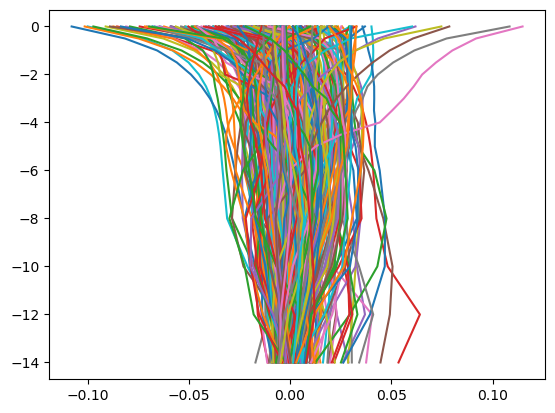

In [75]:
for x in v_selected.time:    
    plt.plot(v_selected.isel(time=x).squeeze(),v_selected.depth)

Text(0.5, 0, 'hours')

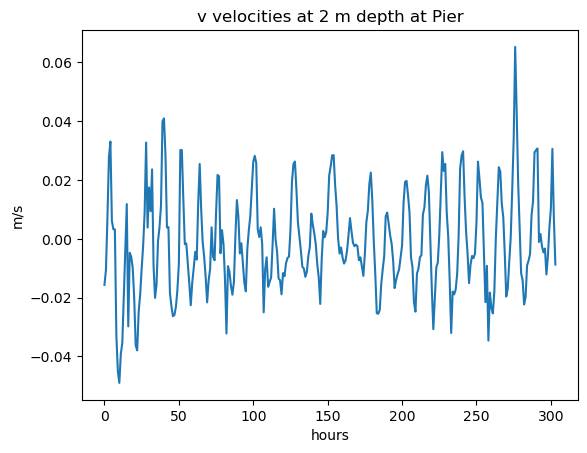

In [78]:
plt.plot(v_selected.sel(depth=-2).isel(time=slice(0,24*14)).squeeze())
plt.title('v velocities at 2 m depth at Pier')
plt.ylabel('m/s')
plt.xlabel('hours')

Text(0.5, 0, 'hours')

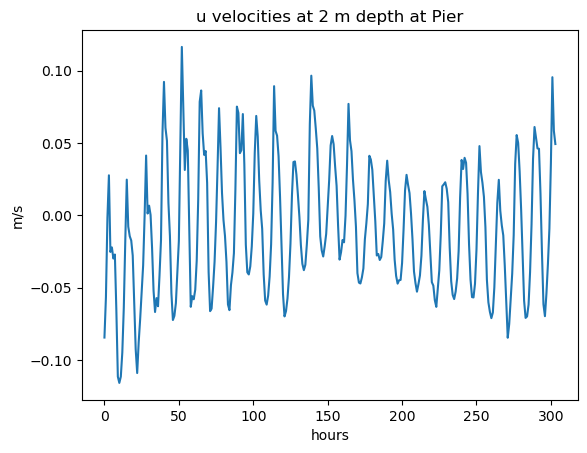

In [79]:
plt.plot(u_selected.sel(depth=-2).isel(time=slice(0,24*14)).squeeze())
plt.title('u velocities at 2 m depth at Pier')
plt.ylabel('m/s')
plt.xlabel('hours')

In [81]:
u_selected

<xarray.DataArray (time: 304, depth: 40)> Size: 49kB
array([[-0.11964038, -0.09908172, -0.090749  , ...,         nan,
                nan,         nan],
       [-0.09258754, -0.07415431, -0.06494422, ...,         nan,
                nan,         nan],
       [-0.03303285, -0.01932863, -0.01065011, ...,         nan,
                nan,         nan],
       ...,
       [ 0.1166491 ,  0.1077029 ,  0.10424862, ...,         nan,
                nan,         nan],
       [ 0.09580833,  0.06834441,  0.0600694 , ...,         nan,
                nan,         nan],
       [ 0.12436003,  0.08550399,  0.06622809, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * depth    (depth) float32 160B -0.0 -0.5 -1.0 -1.5 ... -240.0 -260.0 -280.0
    lon      float64 8B 338.5
    lat      float64 8B 64.39
Dimensions without coordinates: time
Attributes:
    regrid_method:  bilinear

Text(0.5, 1.0, 'velocities at 2 m depth in ROMS at oil pier (deci m/s)')

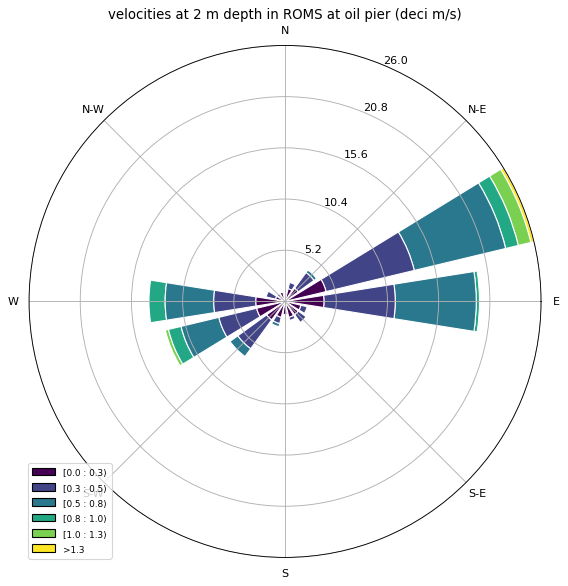

In [92]:
from windrose import WindroseAxes


speed=np.sqrt(u_selected.sel(depth=-2).values**2+v_selected.sel(depth=-2).values**2)
direction= (np.arctan2(-u_selected.sel(depth=-2).values, -v_selected.sel(depth=-2).values) * (180 / np.pi) + 360) % 360

ax = WindroseAxes.from_ax()
ax.bar(direction, speed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.set_title('velocities at 2 m depth in ROMS at oil pier (deci m/s)')

